<a href="https://colab.research.google.com/github/Anirudh-Senani/Flipr_Hackathon_7_2020/blob/main/Flipr_ML_hackathon_7_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.optimizers import SGD

In [2]:
!git clone https://github.com/Anirudh-Senani/Flipr_Hackathon_7_2020/

Cloning into 'Flipr_Hackathon_7_2020'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 16 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (16/16), done.


# Loading and Examining Train Data

In [3]:
# Loading sheet 'Train_Data' from Data.xlsx into train_data pandas DataFrame 
train_data = pd.read_excel("/content/Flipr_Hackathon_7_2020/Data.xlsx",sheet_name='Train_Data', index_col = "PLAYER")
train_data.head()

,Mat,Inns,NO,2018_Runs,HS,Avg,BF,SR,100,50,4s,6s,2019_Runs
PLAYER,,,,,,,,,,,,,
Aaron Finch,10,9,1,134,46,16.75,100,134.00,0,0,6,8,160
AB de Villiers,12,11,2,480,90*,53.33,275,174.54,0,6,39,30,424
Abhishek Sharma,3,3,2,63,46*,63,33,190.90,0,0,3,5,63
Ajinkya Rahane,15,14,1,370,65*,28.46,313,118.21,0,1,39,5,396
Alex Hales,6,6,0,148,45,24.66,118,125.42,0,0,13,6,165


In [4]:
# examine data types 
train_data.dtypes

Mat            int64
Inns           int64
NO             int64
2018_Runs      int64
HS            object
Avg           object
BF             int64
SR           float64
100            int64
50             int64
4s             int64
6s             int64
2019_Runs      int64
dtype: object

# Cleaning Train Data

In [5]:
# found mixed data types in 'HS' column i.e., some numbers are denoted with '*'
# the end representing not out.
# Removing incosistencies in 'HS' column using regex operations to remove non-digits from string.  
train_data.HS = train_data.HS.astype('str').str.replace(r'[^\d.]+', '').astype('int64')

In [6]:
train_data.dtypes

Mat            int64
Inns           int64
NO             int64
2018_Runs      int64
HS             int64
Avg           object
BF             int64
SR           float64
100            int64
50             int64
4s             int64
6s             int64
2019_Runs      int64
dtype: object

In [7]:
# found missing values in 'Avg' column replacing them with corresponding '2018_Runs' column data 
train_data.loc[train_data.Avg == '-', 'Avg'] = train_data['2018_Runs'].loc[train_data.Avg == '-'].copy()
train_data.Avg = train_data.Avg.astype('float64')

In [8]:
train_data.dtypes

Mat            int64
Inns           int64
NO             int64
2018_Runs      int64
HS             int64
Avg          float64
BF             int64
SR           float64
100            int64
50             int64
4s             int64
6s             int64
2019_Runs      int64
dtype: object

#Feature Selection & Representing Train Data

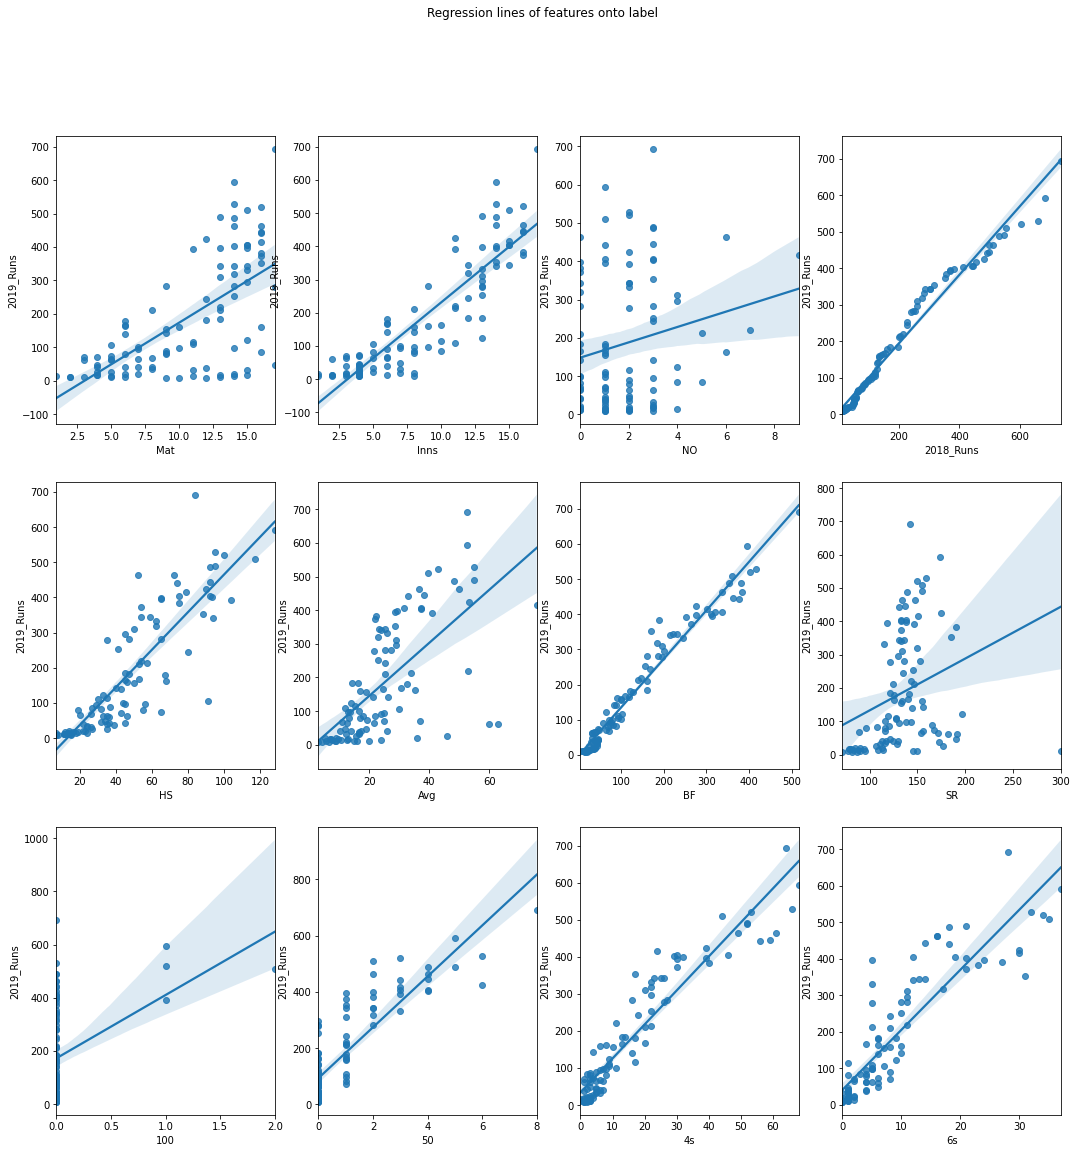

In [9]:
#plotting regreesion lines to all columns on 2019_Runs so we can eliminate redundant features.
features = np.array(train_data.columns[0:12])
features = features.reshape(3,4)
fig, axs = plt.subplots(3,4, figsize = (18,18))
fig.suptitle('Regression lines of features onto label')
for i in range(0,3):
  for j in range(0,4):
    sns.regplot(x = train_data[features[i][j]], y = '2019_Runs', data= train_data, ax = axs[i, j])

In [10]:
# NO feature seem to be redundant so proceeding to loading test data 

# Loading and Examining Test Data

In [11]:
# Loading sheet 'Test_Data' from Data.xlsx into test_data pandas DataFrame 
test_data = pd.read_excel("/content/Flipr_Hackathon_7_2020/Data.xlsx", 'Test_Data', index_col= 'PLAYER')
test_data.head()

,Mat,Inns,NO,2019_Runs,HS,Avg,BF,SR,100,50,4s,6s
PLAYER,,,,,,,,,,,,
David Warner,12,12,2,692,100*,69.2,481,143.86,1,8,57,21
KL Rahul,14,14,3,593,100*,53.9,438,135.38,1,6,49,25
Quinton de Kock,16,16,1,529,81,35.26,398,132.91,0,4,45,25
Shikhar Dhawan,16,16,1,521,97*,34.73,384,135.67,0,5,64,11
Andre Russell,14,13,4,510,80*,56.66,249,204.81,0,4,31,52


In [12]:
# examine data types 
test_data.dtypes

Mat            int64
Inns           int64
NO             int64
2019_Runs      int64
HS            object
Avg           object
BF             int64
SR           float64
100            int64
50             int64
4s             int64
6s             int64
dtype: object

# Cleaning Test Data

In [13]:
# found mixed data types in 'HS' column i.e., some numbers are denoted with '*'
# the end representing not out.
# Removing incosistencies in 'HS' column using regex operations to remove non-digits from string.
test_data.HS = test_data.HS.astype('str').str.replace(r'[^\d.]+', '').astype('int64')

In [14]:
 test_data.dtypes

Mat            int64
Inns           int64
NO             int64
2019_Runs      int64
HS             int64
Avg           object
BF             int64
SR           float64
100            int64
50             int64
4s             int64
6s             int64
dtype: object

In [15]:
# found missing values in 'Avg' column replacing them with corresponding '2019_Runs' column data 
test_data.loc[test_data.Avg == '-', 'Avg'] = test_data['2019_Runs'].loc[test_data.Avg == '-'].copy()
test_data.Avg = test_data.Avg.astype('float64')

In [16]:
test_data.dtypes

Mat            int64
Inns           int64
NO             int64
2019_Runs      int64
HS             int64
Avg          float64
BF             int64
SR           float64
100            int64
50             int64
4s             int64
6s             int64
dtype: object

# Making Features and Label pairs for training

In [17]:
# copy train_data to X and '2019_Runs' column to y
X = train_data.copy(deep = True)
y = train_data['2019_Runs'].copy()

In [18]:
# keep only features in X. 
X = X.drop("2019_Runs", axis=1)

In [19]:
X.head()

,Mat,Inns,NO,2018_Runs,HS,Avg,BF,SR,100,50,4s,6s
PLAYER,,,,,,,,,,,,
Aaron Finch,10,9,1,134,46,16.75,100,134.00,0,0,6,8
AB de Villiers,12,11,2,480,90,53.33,275,174.54,0,6,39,30
Abhishek Sharma,3,3,2,63,46,63.00,33,190.90,0,0,3,5
Ajinkya Rahane,15,14,1,370,65,28.46,313,118.21,0,1,39,5
Alex Hales,6,6,0,148,45,24.66,118,125.42,0,0,13,6


In [20]:
# Removing '2018_Runs' after making a copy to 'tot_runs' column
# because the test set doesn't contain the column name '2018_runs'
# the model considers test set as a different specification and doesn't allow to
# pass test set through the model.
X['tot_runs'] = X['2018_Runs'].copy()
X = X.drop("2018_Runs", axis=1)
X.head()

,Mat,Inns,NO,HS,Avg,BF,SR,100,50,4s,6s,tot_runs
PLAYER,,,,,,,,,,,,
Aaron Finch,10,9,1,46,16.75,100,134.00,0,0,6,8,134
AB de Villiers,12,11,2,90,53.33,275,174.54,0,6,39,30,480
Abhishek Sharma,3,3,2,46,63.00,33,190.90,0,0,3,5,63
Ajinkya Rahane,15,14,1,65,28.46,313,118.21,0,1,39,5,370
Alex Hales,6,6,0,45,24.66,118,125.42,0,0,13,6,148


In [21]:
# Removing '2019_Runs' after making a copy to 'tot_runs' column
# because the train set doesn't contain the column name '2019_runs'
# the model considers train set as a different specification and doesn't allow to
# pass test set through the model.
X_test = test_data.copy(True)
X_test['tot_runs'] = X_test['2019_Runs'].copy()
X_test = X_test.drop('2019_Runs', axis=1)
X_test.head()

,Mat,Inns,NO,HS,Avg,BF,SR,100,50,4s,6s,tot_runs
PLAYER,,,,,,,,,,,,
David Warner,12,12,2,100,69.20,481,143.86,1,8,57,21,692
KL Rahul,14,14,3,100,53.90,438,135.38,1,6,49,25,593
Quinton de Kock,16,16,1,81,35.26,398,132.91,0,4,45,25,529
Shikhar Dhawan,16,16,1,97,34.73,384,135.67,0,5,64,11,521
Andre Russell,14,13,4,80,56.66,249,204.81,0,4,31,52,510


# Train, Validation and Test set splitting

In [22]:
# Splitting data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, test_size=0.3,random_state=0)

# Normalization of features and labels

In [23]:
# normalizing makes all features to a specific range
# so no featue is given more or less weightage
# and normalizing labels results in lesser loss so model can improve more.
feature_scaler = MinMaxScaler()
feature_scaler.fit(X_train)

y_train_ar = np.array(y_train).reshape(len(y_train), 1)
y_valid_ar = np.array(y_valid).reshape(len(y_valid), 1)
label_scaler = MinMaxScaler()
label_scaler.fit(y_train_ar)

X_train_norm = feature_scaler.transform(X_train)
X_train_norm = pd.DataFrame(X_train_norm, index=X_train.index, columns= X_train.columns)

X_valid_norm = feature_scaler.transform(X_valid)
X_valid_norm = pd.DataFrame(X_valid_norm, index=X_valid.index, columns= X_valid.columns)

X_test_norm  = feature_scaler.transform(X_test)
X_test_norm  = pd.DataFrame(X_test_norm, index=X_test.index, columns= X_test.columns)

y_train_norm = label_scaler.transform(y_train_ar)
y_train_norm = y_train_norm.reshape(len(y_train_norm))
y_train_norm = pd.Series(y_train_norm, index=y_train.index,  name= y_train.name)

y_valid_norm = label_scaler.transform(y_valid_ar)
y_valid_norm = y_valid_norm.reshape(len(y_valid_norm))
y_valid_norm = pd.Series(y_valid_norm, index= y_valid.index, name= y_valid.name)

# Specifying Regression Model Architecture and training

In [24]:
# Training a XGBRegressor 
reg_model = XGBRegressor(objective='reg:squarederror', n_estimators=1500, learning_rate=0.09)
def RegModelEvaluate(model,train_df, valid_df, train_label, valid_label, early_stopping = 50):
  """
  inputs : 
  model = model
  train_df = training data frame,
  valid_df = validation data frame,
  train_label = training labels,
  valid_label = validation labels,
  early_stopping = no. rounds to consider in early stopping default : 50,

  outputs:
  prints MSE and MAE of training and validation data
  """

  reg_model.fit(X_train, y_train, 
              early_stopping_rounds= early_stopping, 
              eval_set=[(X_valid, y_valid)], 
              verbose=False)

  print("Training MSE:",mean_squared_error(train_label, reg_model.predict(train_df)))
  print("Training MAE:",mean_absolute_error(train_label, reg_model.predict(train_df)))
  print("Validation MSE:",mean_squared_error(valid_label, reg_model.predict(valid_df)))
  print("Validation MAE:",mean_absolute_error(valid_label, reg_model.predict(valid_df)))

In [25]:
# MSE and MAE of regression model without normalization
print("Regression model evaluation without normalization") 
RegModelEvaluate(reg_model,X_train, X_valid, y_train, y_valid)

Regression model evaluation without normalization
Training MSE: 0.00012835404420132233
Training MAE: 0.008385917118617466
Validation MSE: 261.68164525558603
Validation MAE: 8.12527847290039


In [26]:
# MSE and MAE of regression model with normalization
print("Regression model evaluation with normalization") 
RegModelEvaluate(reg_model,X_train_norm, X_valid_norm, y_train_norm, y_valid_norm)

Regression model evaluation with normalization
Training MSE: 81.57675414230573
Training MAE: 9.030433667212245
Validation MSE: 80.72391378042434
Validation MAE: 8.98232994628802


In [27]:
# denormalizing the predictions calculated using normalized features
reg_norm_predictions = reg_model.predict(X_valid_norm)
reg_norm_predictions = reg_norm_predictions.reshape(len(reg_norm_predictions),1)
reg_norm_predictions = label_scaler.inverse_transform(reg_norm_predictions)
reg_norm_predictions = reg_norm_predictions.reshape(len(reg_norm_predictions))
reg_norm_predictions = pd.Series(reg_norm_predictions, y_valid_norm.index)

# loss of denormalized predictions w.r.t validation data
mean_squared_error(y_valid, reg_norm_predictions)

37656816.14547041

In [28]:
# so normalizing data didn't help rather worsened the model performance for 
# Regression Model

# Specifying NN Model Architecture and Training

In [29]:
#Training a NN model with 2 hidden layers,MSE loss function and SGD optimizer 
nn_model = tf.keras.Sequential([
      tf.keras.layers.Dense(12, 'relu', input_dim = 12),
      tf.keras.layers.Dense(144, 'relu'),
      tf.keras.layers.Dense(1)                                
  ])
def NNModelEvaluate(model,train_df, valid_df, train_label, valid_label, epochs = 50):
  """
  inputs :
  model =  model 
  train_df = training data frame,
  valid_df = validation data frame,
  train_label = training labels,
  valid_label = validation labels,
  early_stopping = no. rounds to consider in early stopping default : 50,
  epochs = No. of iterations default : 50

  outputs:
  prints MSE and MAE of training and validation data
  """
  nn_model.compile(optimizer='adam',loss = 'MSE')
  nn_model.fit(train_df, train_label, epochs = epochs, validation_data = (valid_df, valid_label))

  print("Training MSE:",mean_squared_error(train_label, nn_model.predict(train_df)))
  print("Training MAE:",mean_absolute_error(train_label, nn_model.predict(train_df)))
  print("Validation MSE:",mean_squared_error(valid_label, nn_model.predict(valid_df)))
  print("Validation MAE:",mean_absolute_error(valid_label, nn_model.predict(valid_df)))

In [30]:
# MSE and MAE of NN model without normalization
print("NN model evaluation without normalization") 
NNModelEvaluate(nn_model,X_train, X_valid, y_train, y_valid, 500)

NN model evaluation without normalization
Epoch 1/500
3/3 [==============================] - 0s 49ms/step - loss: 63672.7930 - val_loss: 61948.0781
Epoch 2/500
3/3 [==============================] - 0s 7ms/step - loss: 53289.4297 - val_loss: 51493.7539
Epoch 3/500
3/3 [==============================] - 0s 7ms/step - loss: 43269.1445 - val_loss: 41579.3984
Epoch 4/500
3/3 [==============================] - 0s 7ms/step - loss: 34630.5742 - val_loss: 32570.2852
Epoch 5/500
3/3 [==============================] - 0s 7ms/step - loss: 26193.5293 - val_loss: 24561.7832
Epoch 6/500
3/3 [==============================] - 0s 7ms/step - loss: 19677.6328 - val_loss: 17605.6992
Epoch 7/500
3/3 [==============================] - 0s 6ms/step - loss: 13954.8389 - val_loss: 12042.1787
Epoch 8/500
3/3 [==============================] - 0s 7ms/step - loss: 9323.0576 - val_loss: 7798.2803
Epoch 9/500
3/3 [==============================] - 0s 7ms/step - loss: 5660.5601 - val_loss: 4724.4121
Epoch 10/500
3/3

In [31]:
# MSE and MAE of NN model with normalization
print("NN model evaluation with normalization") 
NNModelEvaluate(nn_model,X_train_norm, X_valid_norm, y_train_norm, y_valid_norm, 625)

NN model evaluation with normalization
Epoch 1/625
3/3 [==============================] - 0s 43ms/step - loss: 0.3470 - val_loss: 0.1962
Epoch 2/625
3/3 [==============================] - 0s 6ms/step - loss: 0.2542 - val_loss: 0.1482
Epoch 3/625
3/3 [==============================] - 0s 7ms/step - loss: 0.2139 - val_loss: 0.1252
Epoch 4/625
3/3 [==============================] - 0s 6ms/step - loss: 0.1842 - val_loss: 0.1032
Epoch 5/625
3/3 [==============================] - 0s 7ms/step - loss: 0.1502 - val_loss: 0.0767
Epoch 6/625
3/3 [==============================] - 0s 8ms/step - loss: 0.1182 - val_loss: 0.0540
Epoch 7/625
3/3 [==============================] - 0s 8ms/step - loss: 0.0823 - val_loss: 0.0390
Epoch 8/625
3/3 [==============================] - 0s 7ms/step - loss: 0.0600 - val_loss: 0.0303
Epoch 9/625
3/3 [==============================] - 0s 7ms/step - loss: 0.0436 - val_loss: 0.0246
Epoch 10/625
3/3 [==============================] - 0s 8ms/step - loss: 0.0327 - val_lo

In [32]:
# denormalizing the predictions calculated using normalized features
nn_norm_predictions  = nn_model.predict(X_valid_norm)
nn_norm_predictions = label_scaler.inverse_transform(nn_norm_predictions)
nn_norm_predictions = nn_norm_predictions.reshape(len(nn_norm_predictions))
nn_norm_predictions = pd.Series(nn_norm_predictions, y_valid_norm.index)

# loss of denormalized predictions w.r.t validation data
print('MSE:',mean_squared_error(y_valid, nn_norm_predictions))
print('MAE:',mean_absolute_error(y_valid, nn_norm_predictions))

MSE: 957.8730421435041
MAE: 18.840961011250815


In [33]:
# so normalizing data didn't help rather worsened the model performance for 
# NN Model either

#Comparison B/w Regreesion and NN Model

In [34]:
# after comparison nn_model without normalization seems to be more accurate.
# ThereFore
final_model = nn_model

# Hyperparameter Tuning

In [35]:
# tune the hyperparameters in the final model for more better results.
# the hyperparameters achieved are 
# train : Validation split =  70 : 30
# no.of epochs =  625, 
# adam optimizer with defaults
# MSE loss function
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, test_size=0.3,random_state=0)
final_model.compile(optimizer='adam',loss= 'MSE')
final_model.fit(X_train, y_train, epochs = 625, validation_data=(X_valid, y_valid))

Epoch 1/625
3/3 [==============================] - 0s 41ms/step - loss: 6612.8481 - val_loss: 3183.5208
Epoch 2/625
3/3 [==============================] - 0s 7ms/step - loss: 1863.7301 - val_loss: 844.7781
Epoch 3/625
3/3 [==============================] - 0s 7ms/step - loss: 598.2731 - val_loss: 924.4627
Epoch 4/625
3/3 [==============================] - 0s 7ms/step - loss: 1065.7867 - val_loss: 1404.0171
Epoch 5/625
3/3 [==============================] - 0s 6ms/step - loss: 1441.8495 - val_loss: 1164.1425
Epoch 6/625
3/3 [==============================] - 0s 7ms/step - loss: 1120.9111 - val_loss: 645.7109
Epoch 7/625
3/3 [==============================] - 0s 7ms/step - loss: 596.1735 - val_loss: 383.7956
Epoch 8/625
3/3 [==============================] - 0s 8ms/step - loss: 327.0660 - val_loss: 471.3593
Epoch 9/625
3/3 [==============================] - 0s 7ms/step - loss: 412.0931 - val_loss: 651.7513
Epoch 10/625
3/3 [==============================] - 0s 10ms/step - loss: 513.0798 

In [36]:
print("Validation MSE:",mean_squared_error(y_valid, final_model.predict(X_valid)))
print("Validation MAE:",mean_absolute_error(y_valid, final_model.predict(X_valid)))

Validation MSE: 140.52020891056506
Validation MAE: 9.239572366078695


i.e., the model predicts the total runs with a difference of ~7 runs


# Making predictions on Test data and Display Result

In [37]:
# making predictions on test data
predictions = pd.Series(final_model.predict(X_test).reshape(len(X_test.index)), index= test_data.index)

# Export the Result 

In [38]:
# Exporting the final result into a csv file
test_data['2020_Runs'] = predictions.astype('int64')
test_data

,Mat,Inns,NO,2019_Runs,HS,Avg,BF,SR,100,50,4s,6s,2020_Runs
PLAYER,,,,,,,,,,,,,
David Warner,12,12,2,692,100,69.20,481,143.86,1,8,57,21,615
KL Rahul,14,14,3,593,100,53.90,438,135.38,1,6,49,25,552
Quinton de Kock,16,16,1,529,81,35.26,398,132.91,0,4,45,25,502
Shikhar Dhawan,16,16,1,521,97,34.73,384,135.67,0,5,64,11,485
Andre Russell,14,13,4,510,80,56.66,249,204.81,0,4,31,52,452
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Carlos Brathwaite,2,2,0,11,6,5.50,10,110.00,0,0,1,0,6
Ishant Sharma,13,3,3,10,10,10.00,3,333.33,0,0,1,1,6
Shakib Al Hasan,3,1,0,9,9,9.00,10,90.00,0,0,0,0,4


In [39]:
test_data.to_excel('/content/Flipr_Hackathon_7_2020/result.xlsx', sheet_name= 'Prediction_Result', columns= test_data.columns)